In [1]:
# Install the necessary libraries for implementing DL: after launching this cell, restart kernel
!pip3 install --user keras scikit-learn pandas opencv-python

     |████████████████████████████████| 378kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 4.6MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 33.2MB/s eta 0:00:01
     |████████████████████████████████| 28.2MB 26.5MB/s eta 0:00:01
     |████████████████████████████████| 276kB 34.9MB/s eta 0:00:01
     |████████████████████████████████| 296kB 32.3MB/s eta 0:00:01
     |████████████████████████████████| 512kB 32.7MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# import the necessary packages

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Input, AveragePooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
#import cv2

Using TensorFlow backend.


In [2]:
# Allocate specific GPU memory fraction for the current session to avoid memory fails

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Load data: images and labels

data = []
labels = []

In [5]:
data = np.array(np.load("../data/all_images_kimeye_224.npy"))
labels = np.array(np.load("../data/all_labels_kimeye.npy"))
labels = labels.astype(int)

In [5]:
"""
data2 = np.array(np.load("../data/all_images_acrima.npy"))
labels2 = np.array(np.load("../data/all_labels_acrima.npy"))
labels2 = labels2.astype(int)
"""

'\ndata2 = np.array(np.load("../data/all_images_acrima.npy"))\nlabels2 = np.array(np.load("../data/all_labels_acrima.npy"))\nlabels2 = labels2.astype(int)\n'

In [5]:
"""
data = np.concatenate((data1, data2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)
"""
print(data.shape)
print(labels[0])

(1544, 224, 224, 3)
0


In [6]:
# shuffle the whole dataset

shuffle = list(zip(data, labels))
np.random.seed(42)
np.random.shuffle(shuffle)
data = np.array([shuffle[i][0] for i in range(len(shuffle))])
labels = np.array([shuffle[i][1] for i in range(len(shuffle))])
del shuffle


In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np_utils.to_categorical(labels)

data = np.array(data)
print(labels)
#labels = np.array(labels)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


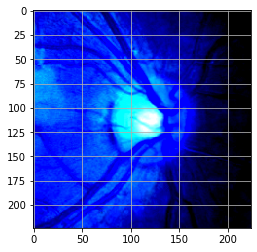

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


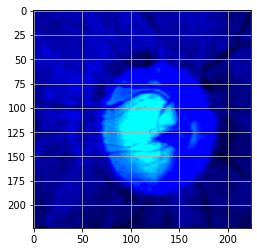

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 1.]


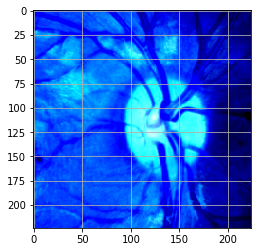

[1. 0.]


In [8]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
	test_size=0.25, random_state=42)

plt.grid(None)

plt.imshow(trainX[10])
plt.show()
print(trainY[10])

plt.grid(None)

plt.imshow(testX[276])
plt.show()
print(testY[276])

plt.grid(None)

plt.imshow(testX[208])
plt.show()
print(testY[208])

In [9]:
# initialize the training data augmentation object

trainAug = ImageDataGenerator(
	rotation_range=40,
	zoom_range=0.2,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32)]


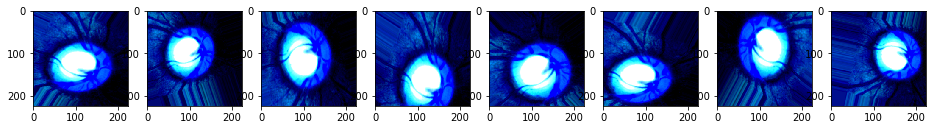

In [10]:
# visualize the different geometric transformations operated to the images

img_id = 600
cat_generator = trainAug.flow(trainX[img_id:img_id+1], 
 trainY[img_id:img_id+1], 
 batch_size=1) 
cat = [next(cat_generator) for i in range(0,8)] 
fig, ax = plt.subplots(1,8, figsize=(16, 6))

print('Labels:', [item[1][0] for item in cat]) 
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,8)]

In [11]:
# load InceptionV3, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 7s 0us/step


In [12]:
# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

[INFO] summary for base model...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)  

In [13]:
# construct the head of the model that will be placed on top of the
# the base model
layer_index = -1
headModel = baseModel.layers[layer_index].output

headModel = GlobalAveragePooling2D()(headModel)

# let's add a fully-connected layer
hidden_units = 256
dropout_rate = 0.0

#headModel = Dense(hidden_units, activation='relu')(headModel)
headModel = Dropout(dropout_rate)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
   layer.trainable = False

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
#opt = Adam(lr=1e-4)
#opt = RMSprop(lr=1e-4)
#lr = 5e-5
lr = 1e-5
momentum = 0.9
decay=1e-6
opt = SGD(lr=lr, momentum=momentum, decay=decay)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
opt_name, _ = str(opt)[18:].split(' ', 1)
print(opt_name)

[INFO] compiling model...
SGD


In [139]:
callbacks =  [EarlyStopping(monitor='val_loss',  patience=20, verbose=1,  mode='auto'),
            ]

In [17]:
epochs = 100
batch_size = 8

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] training head...
Epoch 1/100
144/144 [==============================] - 14s 99ms/step - loss: 0.6931 - accuracy: 0.5139 - val_loss: 0.7169 - val_accuracy: 0.5062
Epoch 2/100
144/144 [==============================] - 12s 86ms/step - loss: 0.6887 - accuracy: 0.5356 - val_loss: 0.6735 - val_accuracy: 0.4880
Epoch 3/100
144/144 [==============================] - 12s 86ms/step - loss: 0.6900 - accuracy: 0.5401 - val_loss: 0.6928 - val_accuracy: 0.4965
Epoch 4/100
144/144 [==============================] - 12s 85ms/step - loss: 0.6875 - accuracy: 0.5400 - val_loss: 0.6795 - val_accuracy: 0.4924
Epoch 5/100
144/144 [==============================] - 12s 85ms/step - loss: 0.6856 - accuracy: 0.5496 - val_loss: 0.6996 - val_accuracy: 0.4922
Epoch 6/100
144/144 [==============================] - 12s 85ms/step - loss: 0.6859 - accuracy: 0.5748 - val_loss: 0.6968 - val_accuracy: 0.5085
Epoch 7/100
144/144 [==============================] - 12s 84ms/step - loss: 0.6837 - accuracy: 0.5783 - v

144/144 [==============================] - 12s 83ms/step - loss: 0.6355 - accuracy: 0.7387 - val_loss: 0.6134 - val_accuracy: 0.7564
Epoch 58/100
144/144 [==============================] - 12s 81ms/step - loss: 0.6255 - accuracy: 0.7565 - val_loss: 0.6531 - val_accuracy: 0.7387
Epoch 59/100
144/144 [==============================] - 12s 83ms/step - loss: 0.6336 - accuracy: 0.7365 - val_loss: 0.6005 - val_accuracy: 0.7635
Epoch 60/100
144/144 [==============================] - 12s 82ms/step - loss: 0.6276 - accuracy: 0.7513 - val_loss: 0.5929 - val_accuracy: 0.7613
Epoch 61/100
144/144 [==============================] - 12s 82ms/step - loss: 0.6350 - accuracy: 0.7231 - val_loss: 0.6214 - val_accuracy: 0.7458
Epoch 62/100
144/144 [==============================] - 12s 83ms/step - loss: 0.6292 - accuracy: 0.7439 - val_loss: 0.5872 - val_accuracy: 0.7635
Epoch 63/100
144/144 [==============================] - 12s 82ms/step - loss: 0.6264 - accuracy: 0.7574 - val_loss: 0.5804 - val_accuracy

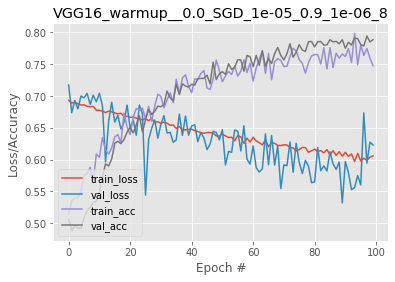

In [19]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
title = "VGG16_warmup_" + '_' + str(dropout_rate)  + '_' + opt_name + '_' + str(lr) + '_' + str(momentum) + '_' + str(decay) + '_' + str(batch_size)
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('../evaluation/VGG16/plots/' + title + '.png')

In [20]:
# save history as a .npy file
np.save('../evaluation/VGG16/history/' + title + '.npy', H)

In [21]:
score = model.evaluate(testX, testY,batch_size=batch_size, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5791619583732723
Test accuracy: 0.787564754486084


In [22]:
# evaluate the network

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
report = classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), output_dict=False)
print(report)


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       209
           1       0.77      0.77      0.77       177

    accuracy                           0.79       386
   macro avg       0.79      0.79      0.79       386
weighted avg       0.79      0.79      0.79       386



In [145]:
import pandas
df = pandas.DataFrame(report).transpose()
df.to_csv('../evaluation/VGG16/report' + title + '.csv', index= True)

In [43]:
# save model and architecture to single file
model.save("../models/VGG16/model" + title + ".h5")
print("Saved model to disk")

Saved model to disk


In [23]:
model.save_weights("../models/VGG16/weights_" + title + ".h5")

In [40]:
baseModel2 = VGG16(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

layer_index = -1
headModel2 = baseModel2.layers[layer_index].output
headModel2 = GlobalAveragePooling2D()(headModel2)

# let's add a fully-connected layer
hidden_units = 256
dropout_rate = 0.0

#headModel2 = Dense(hidden_units, activation='relu')(headModel2)
headModel2 = Dropout(dropout_rate)(headModel2)
headModel2 = Dense(2, activation="softmax")(headModel2)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model2 = Model(inputs=baseModel2.input, outputs=headModel2)

In [41]:
model2.load_weights("../models/VGG16/weights_VGG16_warmup__0.0_SGD_1e-05_0.9_1e-06_8.h5")

In [42]:
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [43]:
fine_tuned_layer_index = -7

#for layer in model2.layers[:fine_tuned_layer_index]:
    #layer.trainable = False
for layer in model2.layers:
    layer.trainable = True

In [44]:
lr = 1e-4
momentum = 0.9
decay=1e-6
opt = SGD(lr=lr, momentum=momentum, decay=decay)
opt_name, _ = str(opt)[18:].split(' ', 1)
print(opt_name)

model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

SGD


In [45]:
# initialize the training data augmentation object

trainAug2 = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug2 = ImageDataGenerator()

In [46]:
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [47]:
epochs = 150
batch_size = 16

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training network...")
H = model2.fit_generator(
	trainAug2.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=valAug2.flow(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)


[INFO] training network...
Epoch 1/150
72/72 [==============================] - 19s 266ms/step - loss: 0.5134 - accuracy: 0.7767 - val_loss: 0.3939 - val_accuracy: 0.8333
Epoch 2/150
72/72 [==============================] - 18s 248ms/step - loss: 0.3822 - accuracy: 0.8398 - val_loss: 0.4372 - val_accuracy: 0.8319
Epoch 3/150
72/72 [==============================] - 18s 248ms/step - loss: 0.3856 - accuracy: 0.8257 - val_loss: 0.1551 - val_accuracy: 0.8531
Epoch 4/150
72/72 [==============================] - 18s 247ms/step - loss: 0.3448 - accuracy: 0.8494 - val_loss: 0.7131 - val_accuracy: 0.8263
Epoch 5/150
72/72 [==============================] - 18s 246ms/step - loss: 0.3284 - accuracy: 0.8660 - val_loss: 0.2138 - val_accuracy: 0.8729
Epoch 6/150
72/72 [==============================] - 18s 253ms/step - loss: 0.3220 - accuracy: 0.8555 - val_loss: 0.3058 - val_accuracy: 0.8701
Epoch 7/150
72/72 [==============================] - 18s 250ms/step - loss: 0.3084 - accuracy: 0.8739 - val_l

72/72 [==============================] - 11s 150ms/step - loss: 0.0557 - accuracy: 0.9807 - val_loss: 0.7767 - val_accuracy: 0.8898
Epoch 114/150
72/72 [==============================] - 11s 148ms/step - loss: 0.0677 - accuracy: 0.9744 - val_loss: 0.4497 - val_accuracy: 0.8757
Epoch 115/150
72/72 [==============================] - 11s 150ms/step - loss: 0.0636 - accuracy: 0.9772 - val_loss: 0.6561 - val_accuracy: 0.8842
Epoch 116/150
72/72 [==============================] - 11s 149ms/step - loss: 0.0611 - accuracy: 0.9825 - val_loss: 0.0316 - val_accuracy: 0.8969
Epoch 117/150
72/72 [==============================] - 11s 150ms/step - loss: 0.0665 - accuracy: 0.9714 - val_loss: 0.3674 - val_accuracy: 0.8941
Epoch 118/150
72/72 [==============================] - 11s 149ms/step - loss: 0.1053 - accuracy: 0.9558 - val_loss: 0.5948 - val_accuracy: 0.8848
Epoch 119/150
72/72 [==============================] - 11s 150ms/step - loss: 0.0965 - accuracy: 0.9661 - val_loss: 0.3824 - val_accuracy:

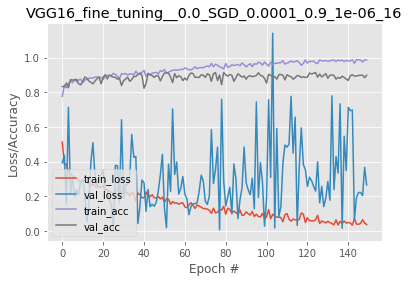

In [54]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
title = "VGG16_fine_tuning_" + '_' + str(dropout_rate) + '_' + opt_name + '_' + str(lr) + '_' + str(momentum) + '_' + str(decay) + '_' + str(batch_size)
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('../evaluation/VGG16/plots/' + title + '.png')


In [51]:
# save model and architecture to single file
model2.save("../models/VGG16/model" + title + ".h5")
print("Saved model to disk")

Saved model to disk


In [49]:
score2 = model2.evaluate(testX, testY,batch_size=batch_size, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Test loss: 0.344471294838221
Test accuracy: 0.8989637494087219


In [50]:
# evaluate the network

print("[INFO] evaluating network...")
predictions2 = model2.predict(testX, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1),
	predictions2.argmax(axis=1)))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       209
           1       0.87      0.92      0.89       177

    accuracy                           0.90       386
   macro avg       0.90      0.90      0.90       386
weighted avg       0.90      0.90      0.90       386

